# ¿How well does a metric learning approach do?

In [1]:
import torch
from functools import partial
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt


# reproducibility
seed = 1993
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data_dir = "./data"

## Load and preprocess data

In [2]:
train_dataset_gpu = {}
eval_dataset_gpu = {}

# dataset
train = torchvision.datasets.CIFAR100(root=data_dir, download=True, transform=transforms.ToTensor())
eval = torchvision.datasets.CIFAR100(root=data_dir, train=False, transform=transforms.ToTensor())

# move dataset to gpu
train_dataset_gpu_loader = torch.utils.data.DataLoader(train, batch_size=len(train), drop_last=True,
                                            shuffle=True, num_workers=2, persistent_workers=False)
eval_dataset_gpu_loader = torch.utils.data.DataLoader(eval, batch_size=len(eval), drop_last=True,
                                            shuffle=False, num_workers=1, persistent_workers=False)
train_dataset_gpu['images'], train_dataset_gpu['targets'] = [item.to(device="cuda", non_blocking=True) for item in next(iter(train_dataset_gpu_loader))]
eval_dataset_gpu['images'],  eval_dataset_gpu['targets']  = [item.to(device="cuda", non_blocking=True) for item in next(iter(eval_dataset_gpu_loader)) ]

# normalize images
train_cifar_std, train_cifar_mean = torch.std_mean(train_dataset_gpu['images'], dim=(0, 2, 3)) 
print(f"Mean: {[f'{x:.4f}' for x in train_cifar_mean.tolist()]}")
print(f"Std: {[f'{x:.4f}' for x in train_cifar_std.tolist()]}")
def batch_normalize_images(input_images, mean, std):
    return (input_images - mean.view(1, -1, 1, 1)) / std.view(1, -1, 1, 1)
batch_normalize_images = partial(batch_normalize_images, mean=train_cifar_mean, std=train_cifar_std)
train_dataset_gpu['images'] = batch_normalize_images(train_dataset_gpu['images'])
eval_dataset_gpu['images']  = batch_normalize_images(eval_dataset_gpu['images'])

data = {
        'train': train_dataset_gpu,
        'eval': eval_dataset_gpu
    }

# pad images for later random cropping
pad_amount = 4
data['train']['images'] = F.pad(data['train']['images'], (pad_amount,)*4, 'reflect')

Files already downloaded and verified


### Metric based data loading

In [3]:
from batch_transforms import batch_crop, batch_flip_lr

@torch.no_grad()
def get_batches(data_dict, key, batchsize, indices=range(100)):
    # select subset of class indices 
    indices = torch.tensor(indices, device=device)
    images, targets = data_dict[key]["images"], data_dict[key]["targets"] 
    samples = torch.isin(targets, indices)
    images, targets = images[samples], targets[samples]
    
    assert len(images) == len(targets)

    # as we are going to pair up the images, we need the size of the dataset to be even
    if len(images) % 2 != 0:
        images = images[:-1]
        targets = targets[:-1]

    num_epoch_examples = len(images)
    shuffled = torch.randperm(num_epoch_examples, device=device)
    crop_size = 32

    # shuffle the dataset
    images = images[shuffled]
    targets = targets[shuffled]

    # transforms
    if key == 'train':
        images = batch_crop(images, crop_size)
        images = batch_flip_lr(images)

    # pair up the dataset
    targets = targets.reshape(num_epoch_examples // 2, 2)
    binary_targets = torch.eq(targets[:,0], targets[:,1])
    # we need that roughly 50% of the pairs are positive and negative
    while binary_targets.float().mean() < 0.5:
        # unpair the target and binary_targets
        targets = targets.reshape(num_epoch_examples)  
        binary_targets = torch.stack([binary_targets, binary_targets], 1).reshape(num_epoch_examples)
        # get negative elements from negative pairs
        neg = binary_targets == False
        # permute them hoping some of them turn into positive pairs
        perm = torch.randperm(len(binary_targets[neg]))
        images[neg] = images[neg][perm]
        targets[neg] = targets[neg][perm]
        # re-pair the targets
        targets = targets.reshape(num_epoch_examples // 2, 2)
        binary_targets = torch.eq(targets[:,0], targets[:,1])
    ## TODO: ensuring 50% distribtution takes much longer than before 
    ## without 50% -> 30 ms
    ## with 50% -> 1 seg
    
    images = images.reshape(num_epoch_examples // 2, 2, 3, images.shape[-1], images.shape[-2])
    num_epoch_examples = len(images)

    for idx in range(num_epoch_examples // batchsize):
        yield images[idx*batchsize: (idx+1)*batchsize, 0], images[idx*batchsize: (idx+1)*batchsize, 1],  binary_targets[idx*batchsize: (idx+1)*batchsize].int()

#### ¿How do I make sure that the implementation is correct?

- ¿Are there any duplicated or overlapping pairs?
    I think there are not since the pairs are selected by reshaping the original 1d-tensor of targets in a matrix with 2 rows, so if there were not any duplicates in the original tensor, then there must not be any duplicates in the pairs. 

In [4]:
%%time 

for x1, x2, y in get_batches(data, "train", 128):
    pass

CPU times: user 1.64 s, sys: 4.89 ms, total: 1.64 s
Wall time: 1.06 s


In [5]:
print(x1.shape)
print(x2.shape)

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


In [6]:
print(y)

tensor([1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
        1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
        1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0', dtype=torch.int32)


In [21]:
idx = 0

10


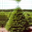

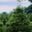

tensor([59, 59], device='cuda:0')
['pine_tree', 'pine_tree']


In [32]:
from torchvision.transforms.functional import to_pil_image
idx_to_class = {i:c for c,i in train.class_to_idx.items()}

print(idx)
display(to_pil_image(x1[idx]))
display(to_pil_image(x2[idx]))

print(y[idx])
# print([idx_to_class[i] for i in y[idx].tolist()])
idx += 1

In [9]:
%%time 

for x, y in old_get_batches(data, "train", 128):
    y

CPU times: user 31.6 ms, sys: 152 µs, total: 31.7 ms
Wall time: 30.7 ms


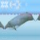

tensor(95, device='cuda:0')


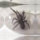

tensor(79, device='cuda:0')


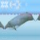

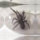

tensor([95, 79], device='cuda:0')


In [10]:
from torchvision.transforms.functional import to_pil_image

n = len(data["train"]["images"])

images_pairs = data["train"]["images"].reshape(n // 2, 2, 3, 40, 40)
labels_pairs = data["train"]["targets"].reshape(n // 2, 2)

# show first and second image
display(to_pil_image(data["train"]["images"][0]))
print(data["train"]["targets"][0])
display(to_pil_image(data["train"]["images"][1]))
print(data["train"]["targets"][1])

# show first pair
display(to_pil_image(images_pairs[0][0]))
display(to_pil_image(images_pairs[0][1]))
print(labels_pairs[0])

## Implement siamese network

### Model definition

In [4]:
x1, x2, y = next(get_batches(data, "train", 128))

In [5]:
print(x1.shape)
print(x2.shape)
print(y.shape)

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128])


In [6]:
from torch import nn
from torchvision.models import resnet18

class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = resnet18()
        self.ndim = self.conv.fc.in_features
        self.conv = nn.Sequential(*list(resnet18().children())[:-1])
        self.fc = nn.Sequential(
            nn.Linear(self.ndim, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 256),
            nn.Linear(256, 2),
        )
     
    def forward_once(self, x):
        x = self.conv(x)  # (bs, ndim, 1, 1)
        x = torch.flatten(x, 1)  # (bs, ndim)
        x = self.fc(x)  # (bs, 2)
        return x 

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)  # (bs, 2)
        output2 = self.forward_once(input2)  # (bs, 2)
        return output1, output2


In [7]:
net = SiameseNetwork()
net.to(device);

In [8]:
out1, out2 = net(x1, x2)
print(out1.shape, out2.shape)

torch.Size([128, 2]) torch.Size([128, 2])


### Classification Mechanism

f() -> (x, y)

1. Calculate mean embedding of each class in the dataset.
2. x -> d(x, mu_i) -> min d(x, mu_i) 1-NN.

## Train model

### Loss function

In [46]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
      loss_contrastive = torch.mean((1-label) * euclidean_distance**2 +
                                    (label) * torch.clamp(self.margin - euclidean_distance, min=0.0)**2)


      return loss_contrastive    

In [ ]:
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005)

### Train and eval methods

In [ ]:
from batch_transforms import get_batches

# training
def train(optimizer, task):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    indices = range(increment * task, increment * (task + 1))
    for batch_idx, (inputs1, inputs2, targets) in enumerate(get_batches(data, "train", batch_size, indices=indices)):
        optimizer.zero_grad()
        outputs1, outputs2 = net(inputs1, inputs2)
        loss = criterion(outputs1, outputs2, targets) if task == 0 else criterion(outputs[:, task * increment:], targets - task * increment)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += len(targets)
        correct += predicted.eq(targets).sum().item()

    return train_loss/(batch_idx + 1), 100.*correct/total

def eval(from_task, to_task):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    indices = range(from_task * increment, (to_task+1) * increment)
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(get_batches(data, "eval", batch_size, indices=indices)):
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += len(targets)
            correct += predicted.eq(targets).sum().item()
        return test_loss/(batch_idx + 1), 100.*correct/total

### Incremental training

## Review results

### Accuracy and loss

### Plot the embedding with t-sne